# **Homogeneous 2D wave equation**:
# $ u_{xx} + u_{yy} + 16\pi^2u + 16\pi^2\sin(4\pi x)\sin(4\pi y) = 0, \qquad 0 < x < 1, \quad 0<y<1, \quad u = u(x,y)$

## Boundary conditions (Dirichlet):
* $ u(x, 0) = 0 \qquad 0 \leq x \leq 1$
* $ u(x, 1) = 0 \qquad 0 \leq x \leq 1$
* $ u(0, y) = 0 \qquad 0 \leq y \leq 1$
* $ u(1, y) = 0 \qquad 0 \leq y \leq 1$

## *ANALYTICAL SOLUTION*
## $ u(x, y) = \sin(4\pi x)\sin(4\pi y) $



In [13]:
!pip install torchsummary
!pip install torchviz
!pip install graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=5167654db71ac23bcc5daaad3f39de53dd764abb014cb5ef1d380fdf82a09741
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from torch.utils.data import Dataset, DataLoader
from scipy.stats import qmc
from scipy.io import loadmat

# Helpers

## Plots

In [14]:
def plot3D(x,t,y):
  # x_plot =x.squeeze(1)
  # t_plot =t.squeeze(1)
  # X,T= torch.meshgrid(x_plot,t_plot)
  F_XY = y
  fig,ax=plt.subplots(1,1)
  # cp = ax.contourf(T,X, F_XY,20,cmap="rainbow")
  cp = ax.contourf(t,x, F_XY,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(t, x, F_XY,cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

## Data

In [15]:
class Data():
  def __init__(self,
               x_min, x_max,
               y_min, y_max,
               Nc, Nl_BC, Nr_BC,
               Nx_test, Ny_test,
               device='cpu',
               dtype=torch.float32,
               EPS=1e-5):

    super().__init__()
    self.x_min = x_min
    self.x_max = x_max
    self.y_min = y_min
    self.y_max = y_max
    self.Nc = Nc
    self.Nl_BC = Nl_BC
    self.Nr_BC = Nr_BC
    self.Nx_test = Nx_test
    self.Ny_test = Ny_test
    self.device = device
    self.dtype = dtype
    self.EPS = EPS

  # ============================= TRAINING DATA ==============================

  # *** Create collocation points ***
  def sample_inside(self, Nc, x_min, x_max, y_min, y_max):
    # Random Grid
    XY_c = qmc.scale(qmc.LatinHypercube(2).random(Nc),
                      [x_min + self.EPS, y_min + self.EPS],
                      [x_max - self.EPS, y_max - self.EPS])
    return torch.tensor(XY_c, dtype=self.dtype, device=self.device)

  # *** Boundary Conditions ***
  # 1. u(x,0) = 0
  # 2. u(x,1) = 0
  # 3. u(0,y) = 0
  # 4. u(1,y) = 0
  def sample_boundary(self, Nl_BC, Nr_BC, x_min, x_max, y_min, y_max):
    xl_BC = np.linspace(x_min, x_max, Nl_BC).reshape(-1, 1)
    yl = np.zeros((Nl_BC, 1))
    XY_x0 = np.concatenate((xl_BC, yl), axis=1)
    XY_x0 = torch.tensor(XY_x0, dtype=self.dtype, device=self.device)

    xr_BC = np.linspace(x_min, x_max, Nr_BC).reshape(-1, 1)
    yr = np.ones((Nr_BC, 1))
    XY_x1 = np.concatenate((xr_BC, yr), axis=1)
    XY_x1 = torch.tensor(XY_x1, dtype=self.dtype, device=self.device)

    xl = np.zeros((Nl_BC, 1))
    yl_BC = np.linspace(y_min, y_max, Nl_BC).reshape(-1, 1)
    XY_0y = np.concatenate((xl, yl_BC), axis=1)
    XY_0y = torch.tensor(XY_0y, dtype=self.dtype, device=self.device)

    xr = np.ones((Nr_BC, 1))
    yr_BC = np.linspace(y_min, y_max, Nr_BC).reshape(-1, 1)
    XY_1y = np.concatenate((xr_BC, yr), axis=1)
    XY_1y = torch.tensor(XY_1y, dtype=self.dtype, device=self.device)

    u_xl = np.zeros(Nl_BC)
    u_xr = np.zeros(Nr_BC)
    u_yl = np.zeros(Nl_BC)
    u_yr = np.zeros(Nr_BC)
    u_xl = torch.tensor(u_xl, dtype=self.dtype, device=self.device)
    u_xr = torch.tensor(u_xr, dtype=self.dtype, device=self.device)
    u_yl = torch.tensor(u_yl, dtype=self.dtype, device=self.device)
    u_yr = torch.tensor(u_yr, dtype=self.dtype, device=self.device)

    return XY_x0, XY_x1, XY_0y, XY_1y, u_xl, u_xr, u_yl, u_yr

  # ============================ VALIDATION DATA =============================
  def sample_validation(self, N_val, x_min, x_max, y_min, y_max):
    # Random Grid
    XY_val = qmc.scale(qmc.LatinHypercube(2).random(N_val), [x_min, y_min], [x_max, y_max])
    return torch.tensor(XY_val, dtype=self.dtype, device=self.device)

  # =============================== TEST DATA ================================
  def sample_test(self, Nx_test, Ny_test, x_min, x_max, y_min, y_max):
    # Uniform Grid
    xc = np.linspace(x_min, x_max, Nx_test)
    yc = np.linspace(y_min, y_max, Ny_test)
    X_mesh, Y_mesh = np.meshgrid(xc, yc)
    XY_test = np.concatenate((X_mesh.flatten().reshape(-1, 1), Y_mesh.flatten().reshape(-1, 1)), axis=1)

    return xc, yc, torch.tensor(XY_test, dtype=self.dtype, device=self.device)

## ANN

In [16]:
class Sin(nn.Module):
  def forward(self, x):
    return torch.sin(x)

In [17]:
class FC_layer(nn.Module):
  def __init__(self,
               in_features,
               out_features,
               activation=nn.Tanh(),
               weight_init=None,
               bias_init=None,):

    super(FC_layer, self).__init__()

    # Define the linear layer with custom weights and biases
    self.linear = nn.Linear(in_features, out_features)
    if weight_init is not None:
      self.linear.weight.data = weight_init(self.linear.weight.data)
    if bias_init is not None:
      self.linear.bias.data = bias_init(self.linear.bias.data)

    # Define the activation function
    self.activation = activation

  def forward(self, x):
    # Forward pass through the linear layer
    x = self.linear(x)

    # Apply the activation function if not None
    if self.activation is not None:
      x = self.activation(x)

    return x

In [18]:
class ResidualBlock(nn.Module):
  def __init__(self,
               in_features,
               fc_out_features,
               linear_out_features,
               activation=nn.Tanh(),
               weight_init=None,
               bias_init=None):

    super(ResidualBlock, self).__init__()

    # A fully-connected layer to change the input dimension
    self.fc_layer = FC_layer(
        in_features=in_features,
        out_features=fc_out_features,
        activation=activation,
        weight_init=weight_init,
        bias_init=bias_init
    )

    # Second linear layer with dimension adjustment
    self.linear = nn.Linear(fc_out_features, linear_out_features)

  def forward(self, x):
    # Apply a normal fully-connected layer
    fc_out = self.fc_layer(x)

    # Apply a linear transformation, so as the 'linear_out'
    #  and 'x' have the same number of features
    linear_out = self.linear(fc_out)

    # Add the input to the output (residual connection)
    output = x + linear_out

    return output

In [19]:
class ResidualFCNN(nn.Module):
  def __init__(self,
               features_dict,
               hidden_activation=Sin(),
               out_activation=None,
               weight_init=None,
               bias_init=None,
               dtype=torch.float32,
               device='cpu'):

    super(ResidualFCNN, self).__init__()
    outer_keys = list(features_dict.keys())
    inner_keys = list(features_dict["res_blocks"].keys())
    keys = [outer_keys[0]] + inner_keys + [outer_keys[-1]]
    n_blocks = len(keys)

    blocks = list()
    for i in range(n_blocks-1):
      if i == 0:
        # 1st block: a simple dense layer to increase the dimensionality
        blocks.append(
            FC_layer(
                in_features=features_dict[keys[i]][0],
                out_features=features_dict[keys[i]][1],
                activation=hidden_activation,
                weight_init=weight_init,
                bias_init=bias_init
            )
        )
      else:
        # Create a bunch of residual blocks
        blocks.append(
            ResidualBlock(
                in_features=features_dict[outer_keys[1]][keys[i]][0],
                fc_out_features=features_dict[outer_keys[1]][keys[i]][1],
                linear_out_features=features_dict[outer_keys[1]][keys[i]][2],
                activation=hidden_activation,
                weight_init=weight_init,
                bias_init=bias_init
            )
        )

    # LAST block: a simple dense layer to decrease the dimensionality
    blocks.append(
        FC_layer(
            in_features=features_dict[keys[-1]][0],
            out_features=features_dict[keys[-1]][1],
            activation=out_activation,
            weight_init=weight_init,
            bias_init=bias_init
        )
    )

    self.net = nn.Sequential(*blocks)

  def forward(self, x):
    return self.net(x)

In [20]:
class FCNN(nn.Module):
  def __init__(self,
               layers,
               hidden_activation=Sin(),
               out_activation=None,
               weight_init=None,
               bias_init=None,
               dtype=torch.float32,
               device='cpu'):

    super(FCNN, self).__init__()
    fc_layers = list()

    for i in range(1, len(layers)-1):
      # Create all layers EXCEPT the LAST one
      fc_layers.append(
          FC_layer(
              in_features=layers[i-1],
              out_features=layers[i],
              activation=hidden_activation,
              weight_init=weight_init,
              bias_init=bias_init
          )
      )

    fc_layers.append(
        FC_layer(
            in_features=layers[len(layers)-2],
            out_features=layers[len(layers)-1],
            activation=out_activation,
            weight_init=weight_init,
            bias_init=bias_init
        )
    )

    self.net = nn.Sequential(*fc_layers)

  def forward(self, x):
    return self.net(x)

In [21]:
class Net(nn.Module):
  def __init__(self,
               blocks,
               hidden_activation=Sin(),
               out_activation=None,
               weight_init=None,
               bias_init=None,
               add_skip_connections=False,
               dtype=torch.float32,
               device='cpu'):

    super(Net, self).__init__()

    if add_skip_connections:
      self.net = ResidualFCNN(
          features_dict=blocks,
          hidden_activation=hidden_activation,
          out_activation=out_activation,
          weight_init=weight_init,
          bias_init=bias_init,
      )
    else:
      self.net = FCNN(
          layers=blocks,
          hidden_activation=hidden_activation,
          out_activation=out_activation,
          weight_init=weight_init,
          bias_init=bias_init,
      )

  def forward(self, x):
    return self.net.forward(x)

### Test ANN

In [22]:
add_skip_connections = False
weight_init = nn.init.xavier_normal_
bias_init = nn.init.zeros_
hidden_activation = Sin()
out_activation = None

if add_skip_connections:
  blocks = {
    "first_fc": [2, 64],
    "res_blocks": {
        "res_0": [64, 128, 64],
        "res_1": [64, 256, 64],
        "res_2": [64, 128, 64],
        "res_3": [64, 64, 64],
    },
    "last_fc": [64, 1]
  }
else:
  n_hidden_layers = 3
  hidden_layer_size = 2
  blocks = [2] + n_hidden_layers * [hidden_layer_size] + [1]

X = torch.randn((10, 2))

net = Net(
    blocks=blocks,
    hidden_activation=hidden_activation,
    out_activation=out_activation,
    weight_init=weight_init,
    bias_init=bias_init,
    add_skip_connections=add_skip_connections
)

output = net(X)

In [23]:
from torchviz import make_dot
from graphviz import Source
from torchsummary import summary

graph = make_dot(output, params=dict(net.named_parameters()))
graph.render("feedforward_with_skip_connections")
# summary(net, (2,))

'feedforward_with_skip_connections.pdf'

In [24]:
print(net)

Net(
  (net): FCNN(
    (net): Sequential(
      (0): FC_layer(
        (linear): Linear(in_features=2, out_features=2, bias=True)
        (activation): Sin()
      )
      (1): FC_layer(
        (linear): Linear(in_features=2, out_features=2, bias=True)
        (activation): Sin()
      )
      (2): FC_layer(
        (linear): Linear(in_features=2, out_features=2, bias=True)
        (activation): Sin()
      )
      (3): FC_layer(
        (linear): Linear(in_features=2, out_features=1, bias=True)
      )
    )
  )
)


## PINN

In [25]:
class MoEPINN():
  def __init__(self,
               x_min, x_max,
               y_min, y_max,
               Nc,
               Nl_BC, Nr_BC,
               N_val,
               Nx_test, Ny_test,
               v,
               blocks,
               gate_blocks,
               epochs,
               patience,
               Nc_resample,
               max_col_points,
               N_BC_increase,
               N_IC_increase,
               N_top_errors,
               N_top_errors_increase,
               hidden_activations,
               add_skip_connections,
               EPS=1e-5,
               chkpt_path='model.pth',
               loss='mse',
               weight_init=None,
               bias_init=None,
               n_models=1,
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.v = torch.tensor(v, dtype=dtype, device=device)
    self.pi = torch.tensor(np.pi, dtype=dtype, device=device)
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience
    self.n_models = n_models
    self.Nc_resample = Nc_resample
    self.max_col_points = max_col_points
    self.N_IC_increase = N_IC_increase
    self.N_top_errors = N_top_errors
    self.N_top_errors_increase = N_top_errors_increase
    self.x_min = x_min
    self.x_max = x_max
    self.y_min = y_min
    self.y_max = y_max
    self.Nc = Nc
    self.N_val = N_val

    # Create Data object
    self.data = Data(x_min, x_max,
                     y_min, y_max,
                     Nc, Nl_BC, Nr_BC,
                     Nx_test, Ny_test,
                     EPS=EPS)

    # Sample data
    self.XY_c = self.data.sample_inside(Nc, x_min, x_max, y_min, y_max)
    self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
    self.XY_val = self.data.sample_validation(N_val, x_min, x_max, y_min, y_max)
    self.xc, self.yc, self.XY_test = self.data.sample_test(Nx_test, Ny_test, x_min, x_max, y_min, y_max)

    # PINNs
    self.pinns = [
        Net(blocks[i],
            hidden_activation=hidden_activations[i],
            out_activation=None,
            weight_init=weight_init,
            bias_init=bias_init,
            add_skip_connections=add_skip_connections[i],
            dtype=dtype,
            device=device)
        for i in range(self.n_models)
    ]

    if self.n_models > 1:
      self.gate = Net(gate_blocks,
                      hidden_activation=Sin(),
                      out_activation=nn.Softmax(dim=1),
                      weight_init=weight_init,
                      bias_init=bias_init,
                      add_skip_connections=False,
                      dtype=dtype,
                      device=device)

    # Loss function
    if loss == 'mse':
      self.loss_fn = nn.MSELoss()
    elif loss == 'mae':
      self.loss_fn = nn.L1Loss()

    # TOTAL PARAMETERS
    all_trainable_params = list()
    for pinn in self.pinns:
      all_trainable_params += pinn.net.parameters()

    # Setting optimizer
    self.optimizer = torch.optim.LBFGS(all_trainable_params,
                                       lr=1,
                                       max_iter=1000,
                                       max_eval=None,
                                       tolerance_grad=1e-07,
                                       tolerance_change=1e-09,
                                       history_size=100,
                                       line_search_fn='strong_wolfe')

  def calculate_u(self, XY):
    for i, pinn in enumerate(self.pinns):
      u = pinn(XY)
      if i == 0:
        u_pinns = u
      else:
        u_pinns = torch.cat((u_pinns, u), dim=1)    # N x self.n_models

    if self.n_models > 1:
      lambdas = self.gate(XY)    # N x self.n_models
      u = torch.sum(u_pinns * lambdas, dim=1)
      return u
    else:
      return u_pinns[0]

  def calculate_pde(self, XY):
    x = XY[:, 0].clone().detach().requires_grad_(True)
    y = XY[:, 1].clone().detach().requires_grad_(True)

    u = self.calculate_u(torch.cat((x.view(-1, 1), y.view(-1, 1)), dim=1))

    u_y = torch.autograd.grad(
        u, y,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_yy = torch.autograd.grad(
        u_y, y,
        grad_outputs=torch.ones_like(u_y),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    pde_res = u_xx + u_yy + self.v * (u.flatten() + torch.sin(4*self.pi*x) * torch.sin(4*self.pi*y))

    return pde_res

  def loss_BC(self):
    u_x0 = self.calculate_u(self.XY_x0)
    u_x1 = self.calculate_u(self.XY_x1)
    u_0y = self.calculate_u(self.XY_0y)
    u_1y = self.calculate_u(self.XY_1y)
    loss_BC = self.loss_fn(u_x0.flatten(), self.u_xl) + \
              self.loss_fn(u_x1.flatten(), self.u_xr) + \
              self.loss_fn(u_0y.flatten(), self.u_yl) + \
              self.loss_fn(u_1y.flatten(), self.u_yr)
    return loss_BC

  def loss_c(self):
    pde_res = self.calculate_pde(self.XY_c)
    return self.loss_fn(pde_res.flatten(), torch.zeros(pde_res.shape[0]))

  def train_loss(self):
    train_loss = self.loss_BC() + self.loss_c()
    return train_loss

  def val_loss(self):
    pde_res = self.calculate_pde(self.XY_val)
    return pde_res, self.loss_fn(pde_res.flatten(), torch.zeros(pde_res.shape[0]))

  def closure(self):
    train_loss = self.train_loss()
    self.optimizer.zero_grad()
    train_loss.backward()
    return train_loss.detach().item()

  def train(self, print_every=1):
    # Start time
    t0 = pd.Timestamp.now()

    # Set model in training mode
    for pinn in self.pinns:
      pinn.net.train()

    train_losses = list()
    val_losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0

      if epoch != 0:
        # Resample ALL collocation points
        self.XY_c = self.data.sample_inside(self.Nc, self.x_min, self.x_max, self.y_min, self.y_max)

        # Sample in high-error locations only if the number of collocation
        # points has not exceeded a predefined threshold
        if self.XY_c.shape[0] < self.max_col_points:

          # Create DataFrame with cols: 'x_test', 'y_test' and 'val_pde_residual'
          XY_val_copy = self.XY_val.clone().detach().numpy()
          pde_abs_errors = np.abs(val_pde_res.clone().detach().numpy()).reshape(-1, 1)
          val_results = np.concatenate((XY_val_copy, pde_abs_errors), axis=1)
          val_results_df = pd.DataFrame(val_results, columns=['x_test', 'y_test', 'val_pde_res'])

          # Define the rectangle where to oversample
          x_min, x_max, y_min, y_max = self.define_rectangle(val_results_df)

          # After calling 'create_valid_rectangle' t's are valid, but x's have changed anew. Therefore
          # I have to call the same function until a valid rectangle is created to be oversampled.
          while x_min == x_max:
            x_min, x_max, y_min, y_max = self.create_valid_rectangle(val_results_df, x_min, x_max, y_min, y_max)

          # Sample new training collocation points in this rectangle
          XY_c_new = self.data.sample_inside(self.Nc_resample, x_min, x_max, y_min, y_max)
          if epoch == 1:
            XY_c_new_pr = XY_c_new.clone()
          else:
            XY_c_new = torch.cat((XY_c_new, XY_c_new_pr), dim=0)
            XY_c_new_pr = XY_c_new.clone()

          # Append the new points to the already existing
          self.XY_c = torch.cat((self.XY_c, XY_c_new), dim=0)

      # Calculate train losses
      train_loss_BC = self.loss_BC().detach().item()
      train_loss_c = self.loss_c().detach().item()

      # Backpropagate the loss
      train_loss = self.optimizer.step(self.closure)

      # Calculate validation loss
      val_pde_res, val_loss = self.val_loss()
      val_loss = val_loss.detach().item()

      train_losses.append(train_loss)
      val_losses.append(val_loss)
      if epoch == 0:
        best_val_loss = val_loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Val loss: {val_loss} - *Checkpoint*")
      else:
        if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % print_every == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Val loss: {val_loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % print_every == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % print_every == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss_BC: {train_loss_BC} | Loss_C: {train_loss_c} | Loss: {train_loss} | Val loss: {val_loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return train_losses, val_losses

  def define_rectangle(self, val_results_df):
    # Sort DataFrame by the absolute PDE-errors and keep 'N_top_errors'
    val_results_df.sort_values(by='val_pde_res', ascending=False, inplace=True)
    top_errors_df = val_results_df.head(self.N_top_errors)

    # EXYract the rectangle with the greatest test errors
    x_min, x_max = top_errors_df['x_test'].min(), top_errors_df['x_test'].max()
    y_min, y_max = top_errors_df['y_test'].min(), top_errors_df['y_test'].max()

    return x_min, x_max, y_min, y_max

  def create_valid_rectangle(self, val_results_df, x_min, x_max, y_min, y_max):

    while x_min == x_max:
      if x_max == self.x_min:                     # x_min = x_max = 0
        # Sample more on the left boundary
        self.Nl_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      elif x_min == self.x_max:                   # x_min = x_max = 1
        # Sample more on the right boundary
        self.Nr_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      else:                                       # x_min = x_max = x
        # Increase self.N_top_errors and resample
        self.N_top_errors += self.N_top_errors_increase

        # Define the rectangle where to oversample
        x_min, x_max, y_min, y_max = self.define_rectangle(val_results_df)

    while y_min == y_max:
      if y_max == self.y_min:                     # y_min = y_max = 0
        # Sample more on the left boundary
        self.Nl_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      elif x_min == self.x_max:                   # x_min = x_max = 1
        # Sample more on the right boundary
        self.Nr_BC += self.N_BC_increase
        self.XY_x0, self.XY_x1, self.XY_0y, self.XY_1y, self.u_xl, self.u_xr, self.u_yl, self.u_yr = self.data.sample_boundary(Nl_BC, Nr_BC, x_min, x_max, y_min, y_max)
      else:                                       # y_min = y_max = y
        # Increase self.N_top_errors and resample
        self.N_top_errors += self.N_top_errors_increase

        # Define the rectangle where to oversample
        x_min, x_max, y_min, y_max = self.define_rectangle(val_results_df)

    return x_min, x_max, y_min, y_max

  def checkpoint(self):
    total_state_dict = {}
    for i, pinn in enumerate(self.pinns):
      total_state_dict[f"expert{i}"] = pinn.net.state_dict()

    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": total_state_dict
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

In [27]:
A = [[1, 2, 3],
     [4, 5, 6],
     [7, 8, 9]]

A = torch.tensor(A)

B = 2*torch.ones(3, 3)

print(A)
print(f"\n{B}")

C = A * B
print(f"\n{C}")

D = torch.sum(C, dim=1)
print(f"\n{D}")

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])

tensor([[2., 2., 2.],
        [2., 2., 2.],
        [2., 2., 2.]])

tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.],
        [14., 16., 18.]])

tensor([12., 30., 48.])


# TRAIN

In [28]:
# ****************** CONFIGURATIONS ******************

# DATA
x_min, x_max = 0, 1
y_min, y_max = 0, 1
Nc = 10_000
Nl_BC = 5_000
Nr_BC = 5_000
N_val = 20_000
Nx_test = 200
Ny_test = 200

# CONSTANTS
v = 16*np.pi**2
EPS = 1e-5
Nc_resample = 500
max_col_points = 100_000
N_top_errors = 1_000
N_top_errors_increase = 1_000
N_BC_increase = 500
N_IC_increase = 500

# NETWORK
EPOCHS = 100
PATIENCE = 5

N_MODELS = 5
N_HIDDEN_LAYERS = [2, 3, 4, 8, 10]
HIDDEN_LAYER_SIZES = [128, 64, 256, 50, 20]
HIDDEN_ACTIVATIONS = [nn.Tanh(), nn.Tanh(), Sin(), nn.Tanh(), Sin()]
ADD_SKIP_CONNECTIONS = N_MODELS * [False]

BLOCKS = []
for i in range(N_MODELS):
  BLOCKS.append([2] + N_HIDDEN_LAYERS[i] * [HIDDEN_LAYER_SIZES[i]] + [1])

GATE_N_HIDDEN_LAYERS = 2
GATE_HIDDEN_LAYER_SIZES = 64
GATE_BLOCKS = [2] + GATE_N_HIDDEN_LAYERS * [GATE_HIDDEN_LAYER_SIZES] + [N_MODELS]

# LOSS
LOSS = 'mse'

# OTHER
CHECKPOINT_PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float32


# ********************* TRAINING *********************
moe_pinn = MoEPINN(
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    Nc=Nc,
    Nl_BC=Nl_BC,
    Nr_BC=Nr_BC,
    N_val=N_val,
    Nx_test=Nx_test, Ny_test=Ny_test,
    v=v,
    blocks=BLOCKS,
    gate_blocks=GATE_BLOCKS,
    epochs=EPOCHS,
    patience=PATIENCE,
    Nc_resample=Nc_resample,
    max_col_points=max_col_points,
    N_top_errors=N_top_errors,
    N_top_errors_increase=N_top_errors_increase,
    N_BC_increase=N_BC_increase,
    N_IC_increase=N_IC_increase,
    hidden_activations=HIDDEN_ACTIVATIONS,
    add_skip_connections=ADD_SKIP_CONNECTIONS,
    EPS=EPS,
    chkpt_path=CHECKPOINT_PATH,
    loss=LOSS,
    n_models=N_MODELS,
    dtype=DTYPE,
    device=DEVICE,
)

train_loss, val_loss = moe_pinn.train(print_every=1)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1/100 | Loss_BC: 0.003588722087442875 | Loss_C: 6254.17236328125 | Loss: 6254.17578125 | Val loss: 248.33099365234375 - *Checkpoint*
Epoch: 2/100 | Loss_BC: 7.448092937469482 | Loss_C: 258.30084228515625 | Loss: 265.7489318847656 | Val loss: 9.44106674194336 - *Checkpoint*
Epoch: 3/100 | Loss_BC: 3.6075518131256104 | Loss_C: 9.831037521362305 | Loss: 13.438589096069336 | Val loss: 2.1910760402679443 - *Checkpoint*
Epoch: 4/100 | Loss_BC: 1.7158105373382568 | Loss_C: 2.217210531234741 | Loss: 3.933021068572998 | Val loss: 1.053408145904541 - *Checkpoint*
Epoch: 5/100 | Loss_BC: 0.7994791269302368 | Loss_C: 1.0630528926849365 | Loss: 1.8625320196151733 | Val loss: 0.6087692975997925 - *Checkpoint*
Epoch: 6/100 | Loss_BC: 0.34859997034072876 | Loss_C: 0.6014436483383179 | Loss: 0.9500436186790466 | Val loss: 0.36069199442863464 - *Checkpoint*
Epoch: 7/100 | Loss_BC: 0.21035367250442505 | Loss_C: 0.36245283484458923 | Loss: 0.5728064775466919 | Val loss: 0.25154319405555725 - *Check

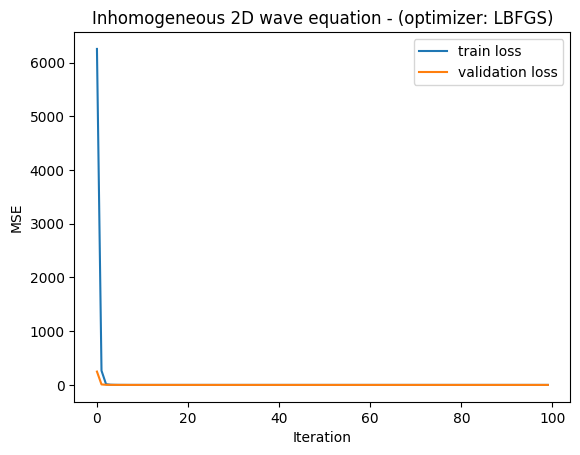

In [29]:
plt.figure()
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.legend()
plt.title("Inhomogeneous 2D wave equation - (optimizer: LBFGS)")
plt.show()

In [30]:
pinn.XY_c.shape

NameError: ignored

In [ ]:
plt.figure(figsize=(30, 10))
plt.scatter(pinn.XY_c[:, 0], pinn.XY_c[:, 1])

# INFERENCE

In [ ]:
# Load best model
print("Loading best model...")
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

# Get test input data
XY_test = pinn.XY_test
x_test = pinn.XY_test[:, 0].flatten()
x_test.requires_grad = True
y_test = pinn.XY_test[:, 1].flatten()
y_test.requires_grad = True

# Calculate real solution
u_test_real = list()
for i in range(XY_test.shape[0]):
  x, y = XY_test[i, 0], XY_test[i, 1]
  u = np.sin(4*np.pi*x) * np.sin(4*np.pi*y)
  u_test_real.append(u)

u_test_real = np.array(u_test_real)

# Calculate PINN's solution and 1st derivative to check initial conditions
u_test_pinn = pinn.feed_forward.forward(torch.cat((x_test.view(-1, 1), y_test.view(-1, 1)), dim=1)).flatten()
u_test_pinn_t = torch.autograd.grad(u_test_pinn, y_test, grad_outputs=torch.ones_like(u_test_pinn), create_graph=True)[0]
u_test_pinn = u_test_pinn.detach().numpy().flatten()
u_test_pinn_t = u_test_pinn_t.detach().numpy().flatten()

# Calculate NMSE (Normalized Mean Square Error)
test_error = u_test_real - u_test_pinn
test_nmse = np.linalg.norm(u_test_real - u_test_pinn, 2) / np.linalg.norm(u_test_real, 2)
print(f'Test NMSE: {test_nmse}')

# Turn off 'requires_grad' and turn pytorch tensors into numpy arrays
x_test.requires_grad_ = False
x_test = x_test.detach().numpy().flatten()
y_test.requires_grad_ = False
y_test = y_test.detach().numpy().flatten()

test_df = pd.DataFrame(
    {
        'y_test': y_test,
        'x_test': x_test,
        'u_test_real': u_test_real,
        'u_test_pinn': u_test_pinn
    }
)
test_df['abs_error'] = abs(test_df['u_test_real'] - test_df['u_test_pinn'])
test_df.to_csv('Inhomogeneous_wave_equation_results.csv', index=False)

Loading best model...


NameError: ignored

# PLOTS

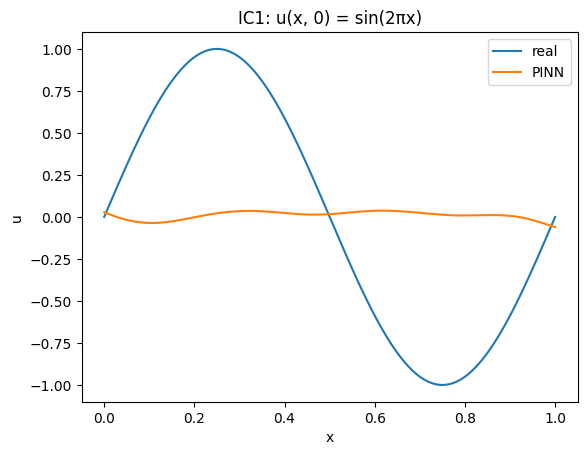

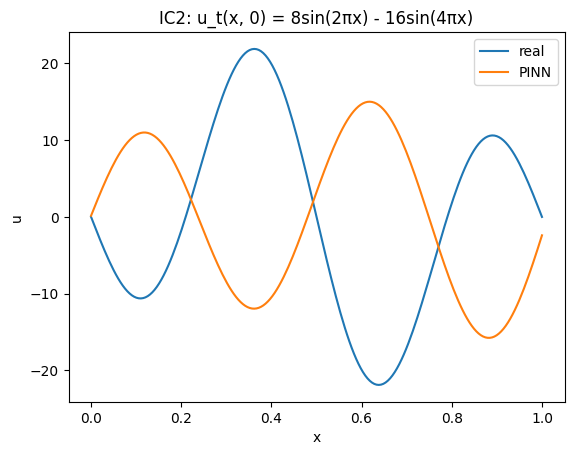

In [ ]:
# Get x's where t=0
t0_df = test_df[test_df['y_test'] == 0.0]
x_t0 = t0_df['x_test'].to_numpy().flatten()

# *** Check 1st Initial Condition ***
u_t0_pinn = t0_df['u_test_pinn'].to_numpy()
u_t0_real = np.sin(2*np.pi*x_t0)

plt.figure()
plt.plot(x_t0, u_t0_real, label='real')
plt.plot(x_t0, u_t0_pinn, label='PINN')
plt.xlabel("x")
plt.ylabel("u")
plt.title("IC1: u(x, 0) = sin(2πx)")
plt.legend()
plt.show()


# *** Check 2nd Initial Condition ***
pos_t0 = np.where(y_test == 0.0)
x_t0 = x_test[pos_t0]
t0 = y_test[pos_t0]
u_t_t0_pinn = u_test_pinn_t[pos_t0]
u_t_t0_real = 8*np.sin(2*np.pi*x_t0) - 16*np.sin(4*np.pi*x_t0)

plt.figure()
plt.plot(x_t0, u_t_t0_real, label='real')
plt.plot(x_t0, u_t_t0_pinn, label='PINN')
plt.xlabel("x")
plt.ylabel("u")
plt.title("IC2: u_t(x, 0) = 8sin(2πx) - 16sin(4πx)")
plt.legend()
plt.show()

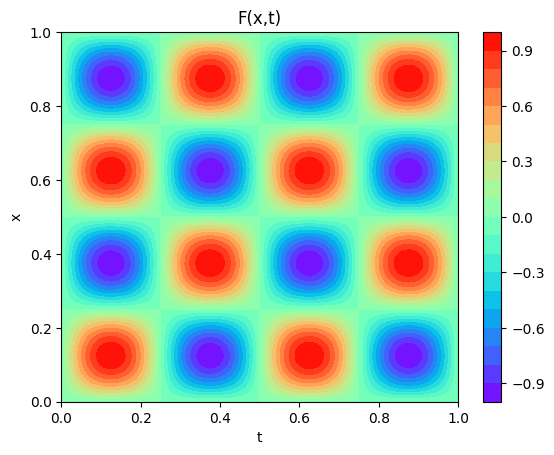

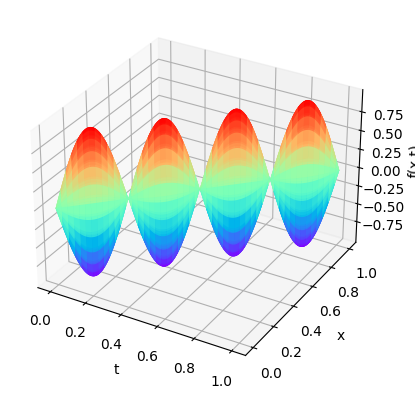

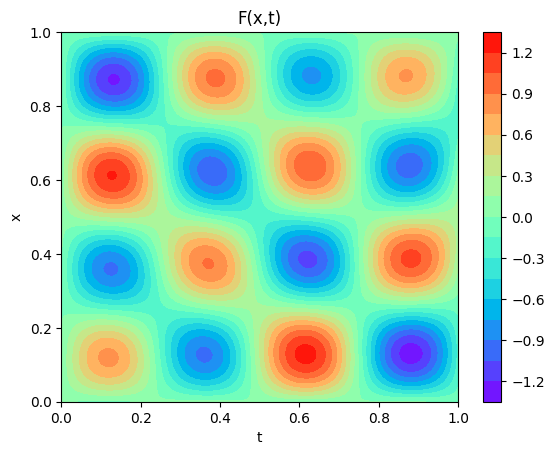

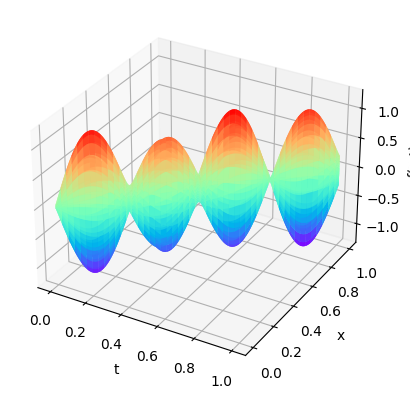

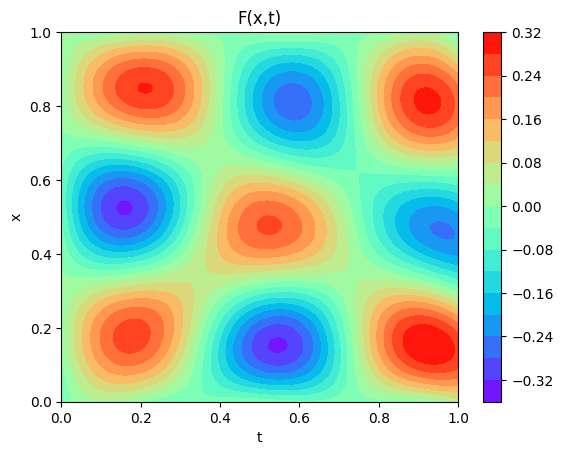

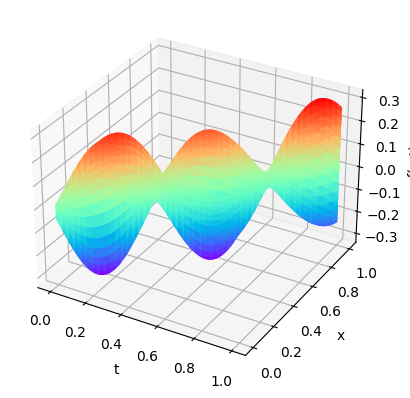

In [ ]:
x_test = pinn.xc
y_test = pinn.yc

u_test_real_2D = u_test_real.reshape(len(x_test), len(y_test))
u_test_pinn_2D = u_test_pinn.reshape(len(x_test), len(y_test))
test_error_2D = test_error.reshape(len(x_test), len(y_test))

plot3D(x_test, y_test, u_test_real_2D)
plot3D(x_test, y_test, u_test_pinn_2D)
plot3D(x_test, y_test, test_error_2D)